In [1]:
import numpy as np
import pandas as pd
import datacube
import time
from multiprocessing import Pool
import itertools
import rasterio
from datacube.utils import masking
import rioxarray
import gc


from datetime import datetime
from odc.ui import DcViewer
from odc.ui import with_ui_cbk

# Set some configurations for displaying tables nicely
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", None)

In [2]:
import sys
from scipy import stats
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import ruptures as rpt
%matplotlib inline
from dea_tools.plotting import display_map, rgb

In [3]:
from datacube.utils.rio import configure_s3_access
from dask.distributed import Client

configure_s3_access(aws_unsigned=False, requester_pays=True)

## Definition of some functions

In [4]:
import datetime


def get_days(df):
    '''converts breaks to days from 2000-01-01'''
    return lambda x: (df.loc[x]['index'] - pd.to_datetime('2000-01-01')).days + 0.0 if x > 0 else np.nan

    
def bkps2dates(array, pena):
    try:
        ixs = len(array)
        df_array = pd.DataFrame(data={'ndvi':array.ravel(), 'ix':np.array(range(ixs))})
        df_array2 = df_array.dropna(how='any')
        model = 'rbf' #"l1", "l2", "rbf"
        algo = ruptures.KernelCPD(kernel=model, min_size=3, jump=5).fit(df_array2['ndvi'].values)
        my_bkps = algo.predict(pen=20)
        if len(my_bkps) > 1:
            return df_array2.reset_index().iloc[my_bkps[-2]-1]['ix']#, df_array2.reset_index().iloc[my_bkps[-2]-1]['index']
        else:
            return np.nan#, pd.to_datetime('1900-01-01')
    except:
        return np.nan
            

In [5]:
def create_df(data, dates):
    df = pd.DataFrame(index=pd.to_datetime(dates),
                            data={'ndvi':data.ravel(), 'ix':range(len(data))})
    df = df.dropna(how='any')
    return df


def model_pelt(df, pen):
    model = 'rbf' #"l1", "l2", "rbf"
    algo = rpt.KernelCPD(kernel=model, min_size=3, jump=5).fit(df['ndvi'].values)
    my_bkps = algo.predict(pen=pen)
    my_bkps = my_bkps[:-1]
    my_bkps = [n-1 for n in my_bkps]
    return my_bkps

        
def bkps2dates2(array, df_dates):
    try:
        df = create_df(array, df_dates)
        my_bkps = model_pelt(df, 20)
        df3 = df.reset_index()
        df3 = df3[df3['index'] > '2016-01-01']
        my_bkps = sorted(list(set(my_bkps).intersection(df3.index.tolist())))
        
        if len(df3.loc[my_bkps]) >= 1:
            days = [df3.loc[n]['index'].year + ((df3.loc[n]['index'] - datetime.datetime(df3.loc[n]['index'].year, 1, 1)).days / 365) for n in my_bkps]
            arr = np.full((5,1),np.nan)
            arr[:len(days)] = np.array(days).reshape(-1, 1)
            bks = [df3.loc[n]['ix'] for n in my_bkps]# if (n.index - pd.to_datetime('1900-01-01')).days > 42368]
            a = np.full((5, 1), np.nan)
            a[:len(bks)] = np.array(bks).reshape(-1, 1)
            ndvis = []
            # for n in my_bkps:
            if len(my_bkps) == 1:
                ndvis.append(df.iloc[my_bkps[0]:]['ndvi'].mean() - df.iloc[:my_bkps[0]]['ndvi'].mean())
            elif len(my_bkps) == 2:
                ndvis.append(df.iloc[my_bkps[0]:my_bkps[1]]['ndvi'].mean() - df.iloc[:my_bkps[0]]['ndvi'].mean())
                ndvis.append(df.iloc[my_bkps[1]:]['ndvi'].mean() - df.iloc[my_bkps[0]:my_bkps[1]]['ndvi'].mean())
            elif len(my_bkps) == 3:
                ndvis.append(df.iloc[my_bkps[0]:my_bkps[1]]['ndvi'].mean() - df.iloc[:my_bkps[0]]['ndvi'].mean())
                ndvis.append(df.iloc[my_bkps[1]:my_bkps[2]]['ndvi'].mean() - df.iloc[my_bkps[0]:my_bkps[1]]['ndvi'].mean())
                ndvis.append(df.iloc[my_bkps[2]:]['ndvi'].mean() - df.iloc[my_bkps[1]:my_bkps[2]]['ndvi'].mean())
            elif len(my_bkps) == 4:
                ndvis.append(df.iloc[my_bkps[0]:my_bkps[1]]['ndvi'].mean() - df.iloc[:my_bkps[0]]['ndvi'].mean())
                ndvis.append(df.iloc[my_bkps[1]:my_bkps[2]]['ndvi'].mean() - df.iloc[my_bkps[0]:my_bkps[1]]['ndvi'].mean())
                ndvis.append(df.iloc[my_bkps[2]:my_bkps[3]]['ndvi'].mean() - df.iloc[my_bkps[1]:my_bkps[2]]['ndvi'].mean())
                ndvis.append(df.iloc[my_bkps[3]:]['ndvi'].mean() - df.iloc[my_bkps[2]:my_bkps[3]]['ndvi'].mean())
            else:
                ndvis.append(df.iloc[my_bkps[0]:my_bkps[1]]['ndvi'].mean() - df.iloc[:my_bkps[0]]['ndvi'].mean())
                ndvis.append(df.iloc[my_bkps[1]:my_bkps[2]]['ndvi'].mean() - df.iloc[my_bkps[0]:my_bkps[1]]['ndvi'].mean())
                ndvis.append(df.iloc[my_bkps[2]:my_bkps[3]]['ndvi'].mean() - df.iloc[my_bkps[1]:my_bkps[2]]['ndvi'].mean())
                ndvis.append(df.iloc[my_bkps[3]:my_bkps[4]]['ndvi'].mean() - df.iloc[my_bkps[2]:my_bkps[3]]['ndvi'].mean())
                ndvis.append(df.iloc[my_bkps[4]:]['ndvi'].mean() - df.iloc[my_bkps[3]:my_bkps[4]]['ndvi'].mean())
            mag = np.full((5, 1), np.nan)
            mag[:len(bks)] = np.array(ndvis).reshape(-1, 1)
            return np.hstack([arr.astype(float).transpose(),
                              a.astype(float).transpose(),
                              mag.astype(float).transpose()])
        else:
            return np.hstack([np.full((5, 1), np.nan).transpose(),
                              np.full((5, 1), np.nan).transpose(),
                              np.full((5, 1), np.nan).transpose()])
    except:
        return np.hstack([np.full((5, 1), np.nan).transpose(),
                          np.full((5, 1), np.nan).transpose(),
                          np.full((5, 1), np.nan).transpose()])        

## Let's define some tiles and sample landsat collection to these boundaries

This should run PELT on these tiles and store breaks and change magnitudes in each case.

In [5]:
tiles_x = [(-71.6, -71.2), (-71.2, -70.8), (-70.8, -70.4), (-70.4, -70.0), (-70.0, -69.6)]
tiles_y = [(-32.6, -32.25), (-32.6, -32.25), (-32.6, -32.25), (-32.6, -32.25), (-32.6, -32.25)]

In [ ]:
for i, n in enumerate(tiles_x[:]):
    dc = datacube.Datacube(app="04_Loading_data")
    ds = dc.load(product=['landsat5_c2l2_sr', 'landsat7_c2l2_sr'],
                 x=n,
                 y=tiles_y[i],
                 time=("2000-01-01", "2023-01-01"),
                 output_crs='EPSG:32719',
                 resolution=(-30,30),
                 progress_cbk=with_ui_cbk(),
                 group_by='solar_day',
                 dask_chunks={"x": 2048, "y": 2048},
                 skip_broken_datasets= True
                )
    good_pixel_flags = {
        "snow": "not_high_confidence",
        "cloud": "not_high_confidence",
        "cloud_shadow": "not_high_confidence",
        "nodata": False
    }
    quality_band = 'qa_pixel'
    cloud_free_mask1 = masking.make_mask(ds[quality_band], **good_pixel_flags)
    ds.update(ds * 0.0000275 + -0.2)
    ndvi = (ds.nir08 - ds.red) / (ds.nir08  + ds.red ).where(cloud_free_mask1)

    dc = datacube.Datacube(app="04_Loading_data")
    ds2 = dc.load(product=["landsat8_c2l2_sr", 'landsat9_c2l2_sr'],
                 x=n,
                 y=tiles_y[i],
                 time=("2000-01-01", "2023-01-01"),
                 output_crs='EPSG:32719',
                 resolution=(-30,30),
                 progress_cbk=with_ui_cbk(),
                 group_by='solar_day',
                 dask_chunks={"x": 2048, "y": 2048},
                 skip_broken_datasets= True
                )
    good_pixel_flags2 = {
        "snow": "not_high_confidence",
        "cloud": "not_high_confidence",
        "cirrus": "not_high_confidence",
        "cloud_shadow": "not_high_confidence",
        "nodata": False
    }
    cloud_free_mask2 = masking.make_mask(ds2[quality_band], **good_pixel_flags2)
    ds2.update(ds2 * 0.0000275 + -0.2)
    ndvi2 = (ds2.nir08 - ds2.red) / (ds2.nir08  + ds2.red ).where(cloud_free_mask2)
    ndvix = xr.concat([ndvi, ndvi2], dim='time')
   
    chunks = ndvix.chunk({'x':50, 'y':50, 'time':len(ndvix.time.values)})
    output1 = xr.apply_ufunc(bkps2dates2, 
                            chunks, 
                             ndvix.time.values,
                            input_core_dims=[['time'], ['time']],
                            output_core_dims=[['new']],
                            exclude_dims=set(("time",)),
                             output_sizes={'new':15},
                            vectorize=True,
                            output_dtypes=[ndvix.dtype],
                            # output_sizes={'size':5},
                             # dask='allowed')
                            dask='parallelized')

    out = output1.compute()
    dates, bks, mags = out.isel(new=range(5)), out.isel(new=range(5,10)), out.isel(new=range(10,15))
    dates.attrs = ds.attrs
    meta = {'driver': 'GTiff',
        'dtype': 'float32',
        'width':dates.shape[1], 
        'height':dates.shape[0],
        'count':5,
        'crs':ds.crs,
        'transform':ds.affine
       }
    with rasterio.open('bks2_1_{}.tif'.format(str(i)), 'w', **meta) as dst:
        dst.write(np.moveaxis(dates.values, 2, 0))
    with rasterio.open('mag2_1_{}.tif'.format(str(i)), 'w', **meta) as dst:
        dst.write(np.moveaxis(mags.values, 2, 0))
    del dc, ds, ds2, ndvi, ndvi2, chunks, output1, out, dates, bks, mags, meta

/tmp/ipykernel_8330/343364721.py:66: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output1 = xr.apply_ufunc(bkps2dates2,
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


## This is a the code for runing PELT on polygons from a shapefile

In [6]:
import geopandas as gpd


gdf = gpd.read_file('data/PolValConsolidadosBosquePlantacion.shp')

In [8]:
gdf['NAME'].unique()

array(['estable', 'tala', 'sequia', 'sequia tala', 'incendio sequia',
       'incendio tala', 'sequia incendio', 'incendio sequia tala',
       'tala sequia', 'tala incendio', 'tala incendio sequia',
       'incendio incendio tala', 'incendio'], dtype=object)

In [23]:
gdf['geometry'] = gdf['geometry'].to_crs('epsg:32719')

In [8]:
estables = gdf[gdf['NAME'] == 'estable']

tala = gdf[((gdf['NAME'] == 'tala') & ~(gdf['ID'].isin(lw2016))) | (gdf['ID'].isin(keep))]

sequia = gdf[gdf['NAME'] == 'sequia']

incendios = gdf[gdf['NAME'] == 'incendio']

               

In [24]:
name = tala['ID'].iloc[0]
print(name)
if tala.geometry.iloc[0].type == 'MultiPolygon':
    x0 = np.min([np.min(n.exterior.xy[0]) for n in tala.geometry.iloc[0].geoms])
    x1 = np.max([np.max(n.exterior.xy[0]) for n in tala.geometry.iloc[0].geoms])
    y0 = np.min([np.min(n.exterior.xy[1]) for n in tala.geometry.iloc[0].geoms])
    y1 = np.max([np.max(n.exterior.xy[1]) for n in tala.geometry.iloc[0].geoms])
else:
    x0, x1 = np.min(tala.geometry.iloc[0].exterior.coords.xy[0]), np.max(tala.geometry.iloc[0].exterior.coords.xy[0])
    y0, y1 = np.min(tala.geometry.iloc[0].exterior.coords.xy[1]), np.max(tala.geometry.iloc[0].exterior.coords.xy[1])
x0 = x0 - 0.02
x1 = x1 + 0.02
y0 = y0 - 0.02
y1 = y1 + 0.02
print(y0, y1, x0, x1)
dc = datacube.Datacube(app="04_Loading_data")
ds = dc.load(product=['landsat5_c2l2_sr', 'landsat7_c2l2_sr'],
             x=(x0, x1),
             y=(y0, y1),
             time=("2000-01-01", "2023-01-01"),
             output_crs='EPSG:32719',
             resolution=(-30,30),
             progress_cbk=with_ui_cbk(),
             group_by='solar_day',
             dask_chunks={"x": 2048, "y": 2048},
             skip_broken_datasets= True
            )
good_pixel_flags = {
    "snow": "not_high_confidence",
    "cloud": "not_high_confidence",
    "cloud_shadow": "not_high_confidence",
    "nodata": False
}
quality_band = 'qa_pixel'
cloud_free_mask1 = masking.make_mask(ds[quality_band], **good_pixel_flags)
ds.update(ds * 0.0000275 + -0.2)
ndvi = (ds.nir08 - ds.red) / (ds.nir08  + ds.red ).where(cloud_free_mask1)

dc = datacube.Datacube(app="04_Loading_data")
ds2 = dc.load(product=["landsat8_c2l2_sr", 'landsat9_c2l2_sr'],
             x=(x0, x1),
             y=(y0, y1),
             time=("2000-01-01", "2023-01-01"),
             output_crs='EPSG:32719',
             resolution=(-30,30),
             progress_cbk=with_ui_cbk(),
             group_by='solar_day',
             dask_chunks={"x": 2048, "y": 2048},
             skip_broken_datasets= True
            )
good_pixel_flags2 = {
    "snow": "not_high_confidence",
    "cloud": "not_high_confidence",
    "cirrus": "not_high_confidence",
    "cloud_shadow": "not_high_confidence",
    "nodata": False
}

cloud_free_mask2 = masking.make_mask(ds2[quality_band], **good_pixel_flags2)
ds2.update(ds2 * 0.0000275 + -0.2)
ndvi2 = (ds2.nir08 - ds2.red) / (ds2.nir08  + ds2.red ).where(cloud_free_mask2)
ndvix = xr.concat([ndvi, ndvi2], dim='time')

81
-34.1075072117 -34.0652857905 -71.78322865269999 -71.7407825411


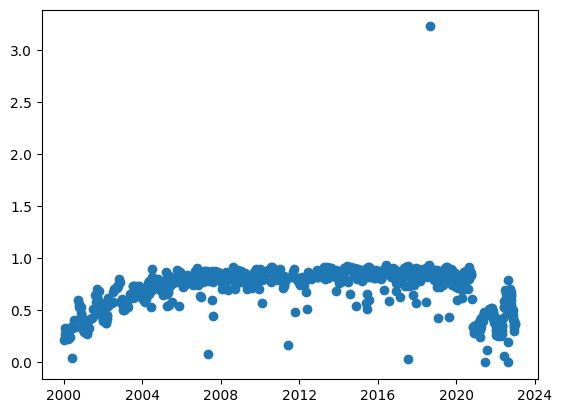

In [44]:
plt.scatter(ndvix.time.values, ndvix.isel(x=5, y=5))
plt.show()

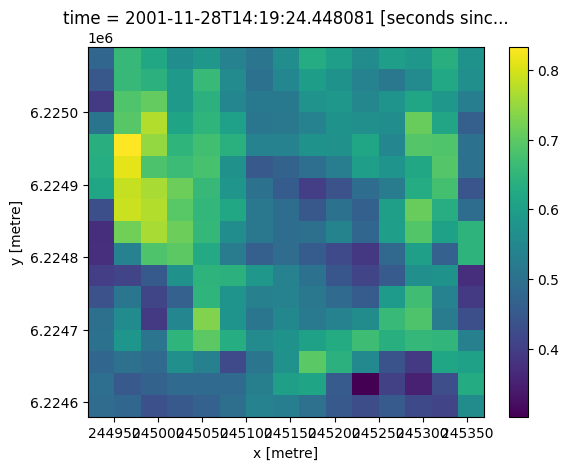

In [45]:
ndvix.isel(time=100).plot()

In [25]:
chunks = ndvix.chunk({'x':50, 'y':50, 'time':len(ndvix.time.values)})
output1 = xr.apply_ufunc(bkps2dates2, 
                         chunks, 
                         ndvix.time.values,
                         input_core_dims=[['time'], ['time']],
                         output_core_dims=[['new']],
                         exclude_dims=set(("time",)),
                         output_sizes={'new':15},
                         vectorize=True,
                         output_dtypes=[ndvix.dtype],
                        # output_sizes={'size':5},
                         # dask='allowed')
                         dask='parallelized')

out = output1.compute()
dates, bks, mags = out.isel(new=range(5)), out.isel(new=range(5,10)), out.isel(new=range(10,15))
dates.attrs = ds.attrs
meta = {'driver': 'GTiff',
        'dtype': 'float32',
        'width':dates.shape[1], 
        'height':dates.shape[0],
        'count':5,
        'crs':ds.crs,
        'transform':ds.affine
       }
with rasterio.open('geo_bkstala_{}.tif'.format('test3'), 'w', **meta) as dst:
    dst.write(np.moveaxis(dates.values, 2, 0))
with rasterio.open('geo_magtala_{}.tif'.format('test3'), 'w', **meta) as dst:
    dst.write(np.moveaxis(mags.values, 2, 0))
del dc, ds, ds2, cloud_free_mask1, cloud_free_mask2, ndvi, ndvi2, ndvix, chunks, output1, out, dates, bks, mags, meta